In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import sys

sys.path.insert(1, '../code')
from featurize_and_fit import Featurizer, Fitter
import plotter
import scalars

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = True
show_intermediate_plots = True
check_cond = False
plot_dir = '../plots/plots_2022-02-15'
!mkdir -p $plot_dir

#tag = '_unc0.1Mfloor2e8'
#tag = '_logxlogy'
#tag = '_rmsfalse'
tag = ''

# r_edges (TNG50-4: L=35 Mpc/h, N_part=270^3, mean interparticle spacing = 35/270 = 0.13 Mpc/h = 130 kpc/h)
# TODO: doesnt work w 4 bins
# n_rbins_arr = np.array([4])
# m_order_max_arr = [3]
# x_order_max_arr = [2] # for scalars, only 0 or 2 x orders 

n_rbins_arr = np.array([4])
m_order_max_arr = [3]
x_order_max_arr = [2] # for scalars, only 0 or 2 x orders 

#y_scalar_feature_name = 'mass_hydro_halo_star'
y_scalar_feature_name='mass_hydro_subhalo_star'


r_units = 'r200'
log_x = False
log_y = False
rms_x = True

l_arr = scalars.get_needed_ls_scalars(np.max(m_order_max_arr), np.max(x_order_max_arr))

In [3]:
mass_multiplier = 1e10

In [4]:
featurizer = Featurizer()
featurizer.read_simulations()
featurizer.match_twins()
featurizer.select_halos()
featurizer.add_info_to_halo_dicts()
featurizer.set_y_labels(y_scalar_feature_name=y_scalar_feature_name)

In [5]:
def broken_power_law_feature(M200, N=0.01, M1=1e12/mass_multiplier, beta=1.5, gamma=0.4):
    return M200*2*N/((M200/M1)**(-beta) + (M200/M1)**gamma)

In [6]:
m200_halo = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer.halo_dicts])
y_val_current = broken_power_law_feature(m200_halo)

In [7]:
m200_halo

array([1.7054902e+04, 8.1548193e+03, 5.7413306e+03, ..., 9.5244986e-01,
       9.3377435e-01, 6.3496655e-01], dtype=float32)

In [8]:
uncertainty_floor = 2e8/mass_multiplier
uncertainties = np.sqrt((0.1*featurizer.y_scalar)**2 + uncertainty_floor**2) # uncertainties are 0.1*M_stellar (M_stellar is our label)

In [9]:
print(featurizer.N_halos)

2344


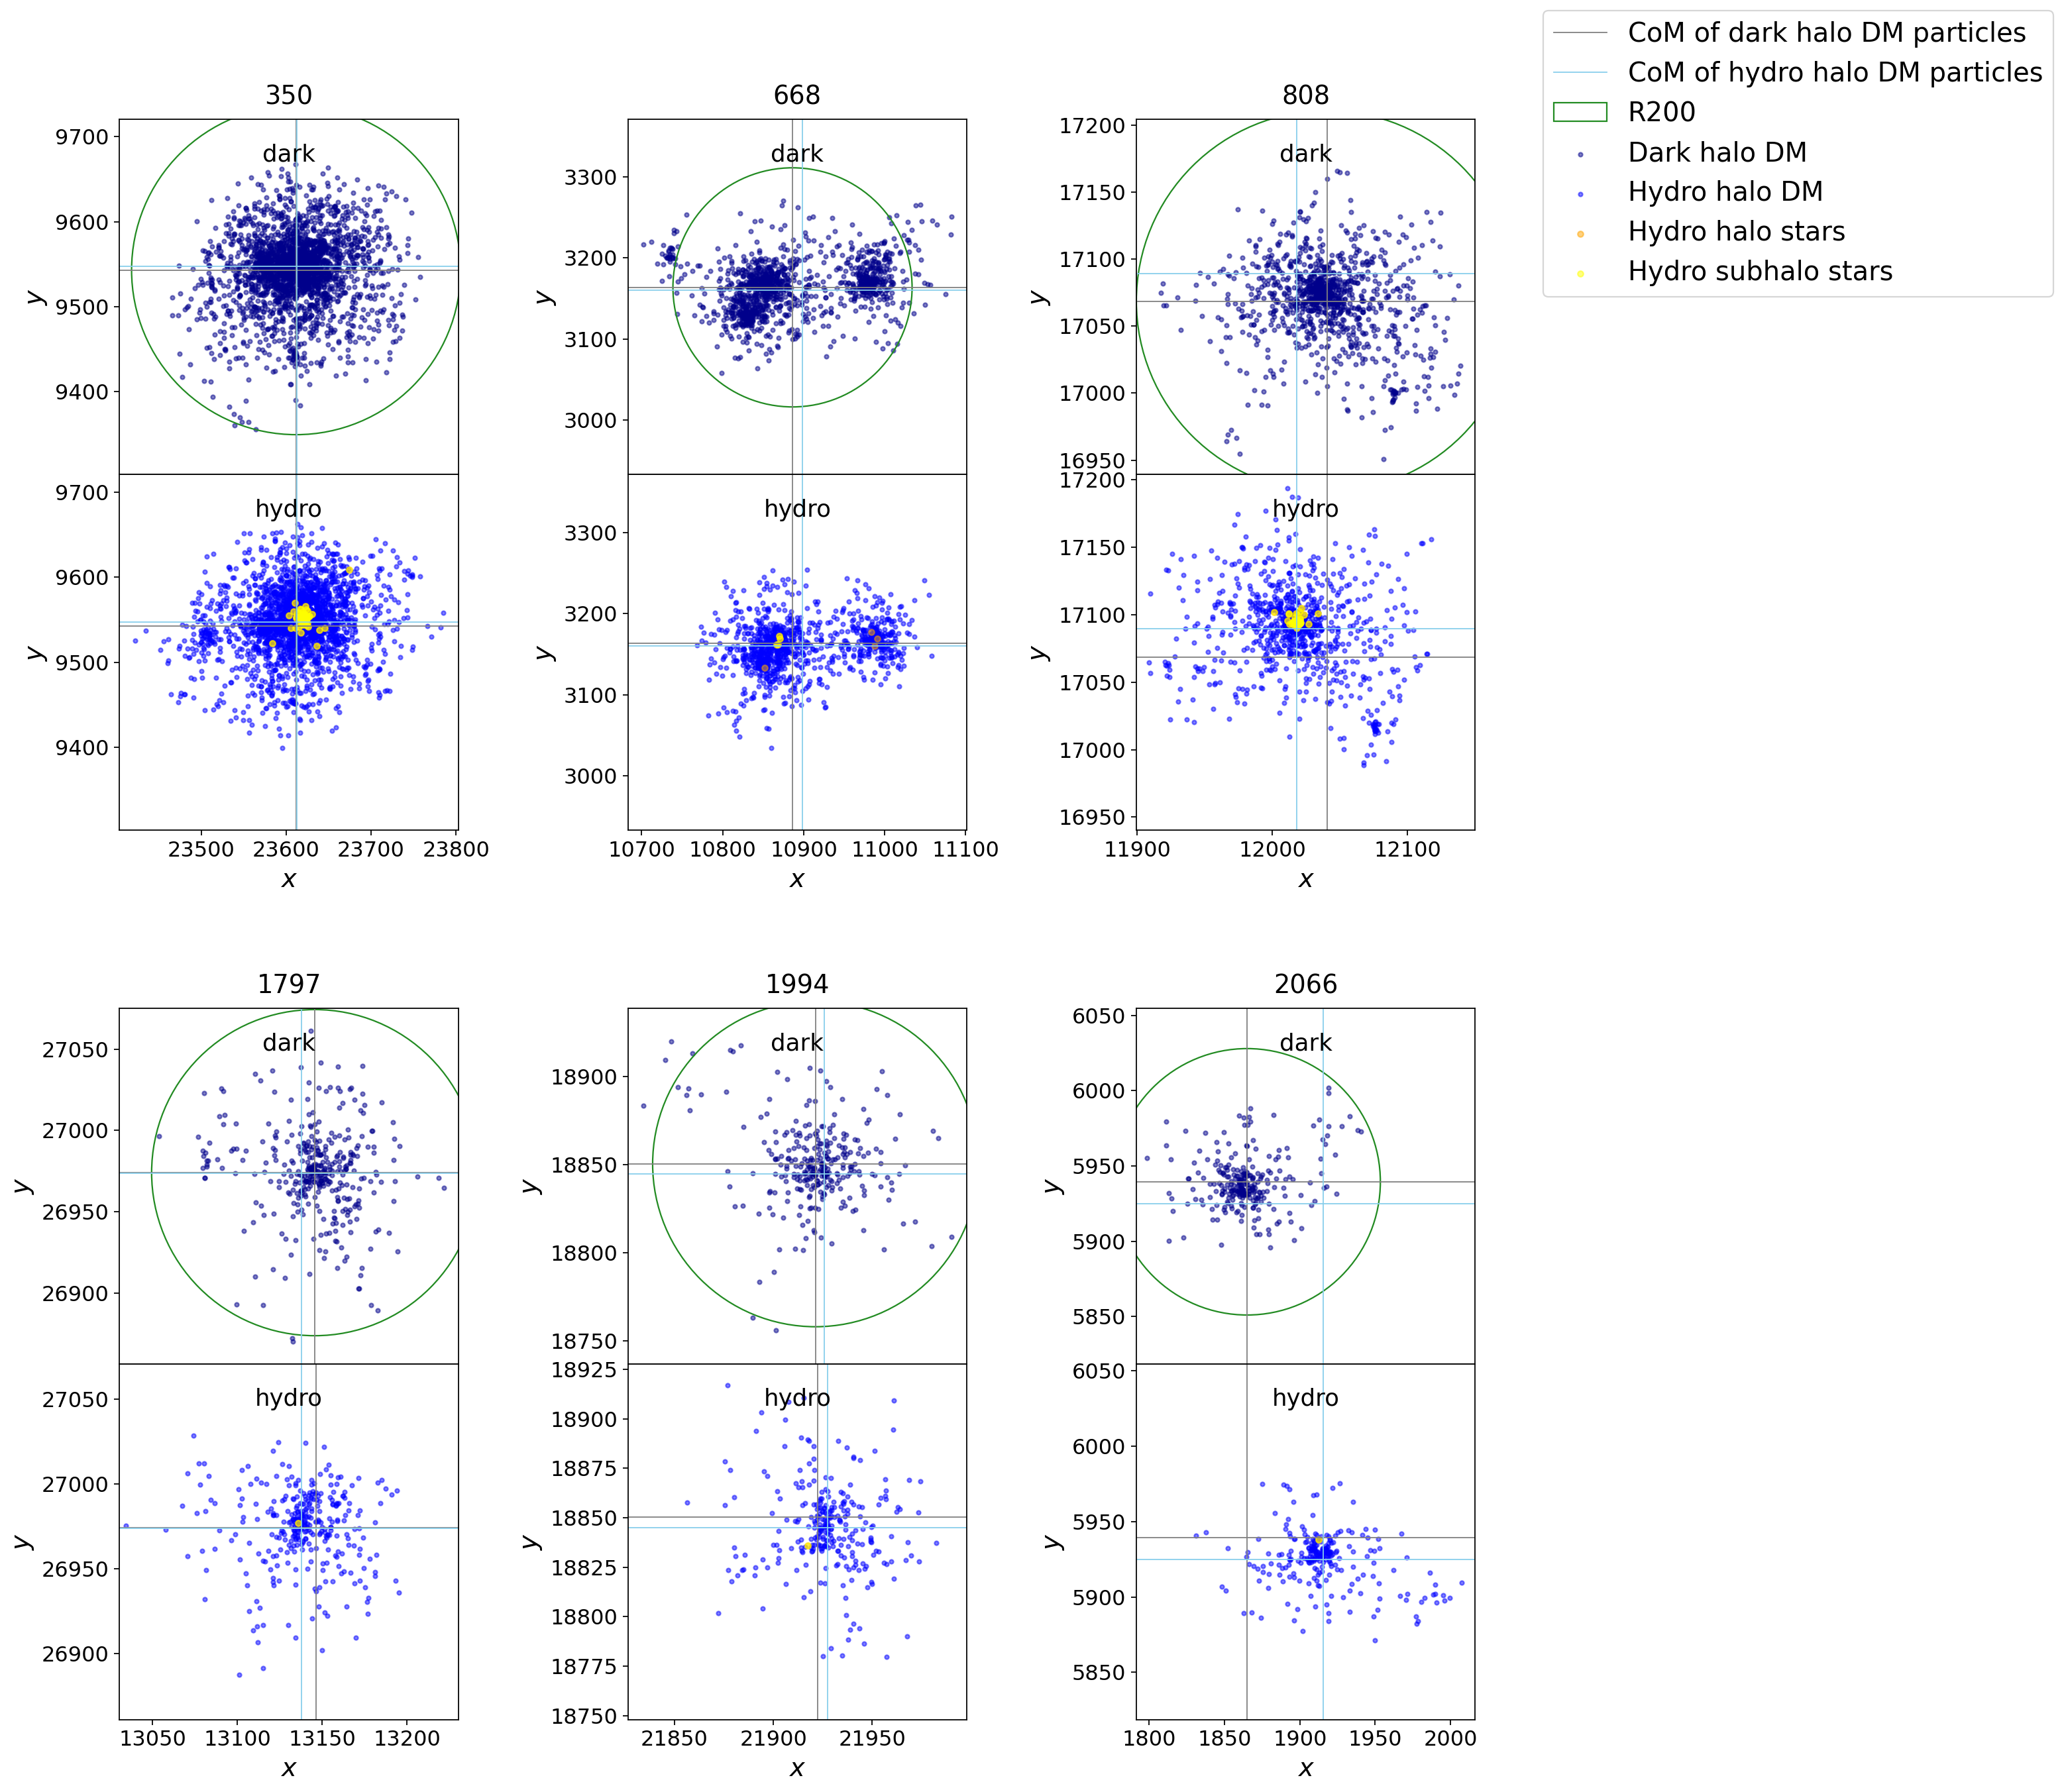

In [10]:
if show_intermediate_plots:
    nrows_outer, ncols_outer = 2, 3
    n_plots = nrows_outer * ncols_outer

    # random sample
    np.random.seed(42)
    idxs_rand = sorted(np.random.choice(featurizer.N_halos, size=n_plots, replace=False))

    halo_dicts_rand = featurizer.halo_dicts[idxs_rand]
    titles = idxs_rand[:n_plots]
    plotter.plot_halos_dark_and_hydro(halo_dicts_rand, nrows_outer, ncols_outer, titles)

In [11]:
def plot_pred_vs_true(y_true, y_pred, y_train, y_train_pred, 
                      fitter, msfe_test, chi2_train, save_fn=None):
    fig = plt.figure(figsize=(6,6))
    ax = plt.gca()

    # main scatter plotting
    plt.scatter(y_train, y_train_pred, s=12, alpha=0.3, c='m', label='training')
    plt.scatter(y_true, y_pred, s=12, alpha=0.6, c='k', label='testing')


    # get limits, plot true line
    m_minmin = min(min(y_true[np.where(y_true > 0)]), 
                   min(y_pred[np.where(y_pred > 0)]))
    m_maxmax = max(max(y_true[np.where(y_true > 0)]), 
                   max(y_pred[np.where(y_pred > 0)]))
    true_line = np.linspace(0.5*m_minmin, 2*m_maxmax)
    plt.plot(true_line, true_line, color='grey', zorder=0)

    # labels & adjustments
    plt.xlabel(r'$m_\mathrm{true}$')
    plt.ylabel(r'$m_\mathrm{pred}$')
    plt.xscale('log')
    plt.yscale('log')
    ax.set_aspect('equal')
    plt.xlim(0.5*m_minmin, 2*m_maxmax)
    plt.ylim(0.5*m_minmin, 2*m_maxmax)

    n_neg = len(np.where(fitter.y_scalar_pred*mass_multiplier < 0)[0])
    plt.text(0.1, 0.9, fr'$n_\mathrm{{features}}$: {fitter.n_features + 2}, rank: {fitter.res_scalar[2]}' '\n'
                       fr'MSFE: {msfe_test:.3e}, $n_\mathrm{{test}}$: {fitter.n_test}' '\n'
                       fr'$\chi^2$: {chi2_train:.3e}, $n_\mathrm{{train}}$: {fitter.n_train}' '\n'
                       fr'# m_pred < 0: {n_neg}', 
             transform=ax.transAxes, verticalalignment='top', fontsize=12)
    plt.title(save_tag)
    plt.legend(loc='lower right', fontsize=12)

    # save
    if save_fn is not None and save_plots:
          plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

In [12]:
def plot_pred_vs_mass(mass, y_true, y_pred, mass_train, y_train, y_train_pred, 
                      fitter, msfe_test, chi2_train, save_fn=None):
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    
    # main scatter plotting
    #plt.scatter(mass_train, y_train_pred, s=12, alpha=0.3, c='m', label='training')
    plt.scatter(mass, y_pred, s=12, alpha=0.2, c='k', label='predicted (test)')
    plt.scatter(mass, y_true, s=12, alpha=0.3, c='c', label='true (test)')

    # get limits, plot true line
    mass_minmin = min(min(mass[np.where(mass > 0)]), 
                   min(mass_train[np.where(mass_train > 0)]))
    mass_maxmax = max(max(mass[np.where(mass > 0)]), 
                   max(mass_train[np.where(mass_train > 0)]))
    y_minmin = min(min(y_pred[np.where(y_pred > 0)]), 
                   min(y_train_pred[np.where(y_train_pred > 0)]))
    y_maxmax = max(max(y_pred[np.where(y_pred > 0)]), 
                   max(y_train_pred[np.where(y_train_pred > 0)]))

    # labels & adjustments
    plt.xlabel(r'$M_\mathrm{halo,DM}$')
    plt.ylabel(r'$m_\mathrm{stellar,pred}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.5*mass_minmin, 2*mass_maxmax)
    plt.ylim(0.5*y_minmin, 2*y_maxmax)

    n_neg = len(np.where(fitter.y_scalar_pred*mass_multiplier < 0)[0])
    plt.text(0.1, 0.9, fr'$n_\mathrm{{features}}$: {fitter.n_features + 2}, rank: {fitter.res_scalar[2]}' '\n'
                       fr'MSFE: {msfe_test:.3e}, $n_\mathrm{{test}}$: {fitter.n_test}' '\n'
                       fr'$\chi^2$: {chi2_train:.3e}, $n_\mathrm{{train}}$: {fitter.n_train}' '\n'
                       fr'# m_pred < 0: {n_neg}', 
             transform=ax.transAxes, verticalalignment='top', fontsize=12)
    plt.title(save_tag)
    plt.legend(loc='lower right', fontsize=12)

    # save
    if save_fn is not None and save_plots:
          plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

In [13]:
def plot_feature_vs_label(featurizer, i_feat=0, feat_label='feature 0 (mass in first bin)'):
    fig = plt.figure(figsize=(6,4))
    x_feat = featurizer.x_scalar_features[:,i_feat] * mass_multiplier
    y_feat = featurizer.y_scalar*mass_multiplier
    plt.scatter(x_feat, y_feat, color='k', s=6, alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    xlim = min(x_feat), max(x_feat)
    plt.xlim(xlim)
    ylim = min(y_feat), max(y_feat)
    plt.ylim(ylim)
    
    plt.xlabel(feat_label)
    plt.ylabel(r'$M_\mathrm{stellar}$')

In [14]:
def plot_feature_vs_mass(masses, featurizer, i_feat=0, feat_label='feature 0 (mass in first bin)'):
    fig = plt.figure(figsize=(6,4))
    x_feat = featurizer.x_scalar_features[:,i_feat] * mass_multiplier
    plt.scatter(masses, x_feat, color='k', s=6, alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    xlim = min(masses), max(masses)
    plt.xlim(xlim)
    ylim = min(x_feat), max(x_feat)
    plt.ylim(ylim)
    
    plt.xlabel(r'$M_\mathrm{200}$ (catalog)')
    plt.ylabel(feat_label)

<ipython-input-13-2b64de3fe749>:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(xlim)
<ipython-input-14-32368542e5c0>:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(ylim)


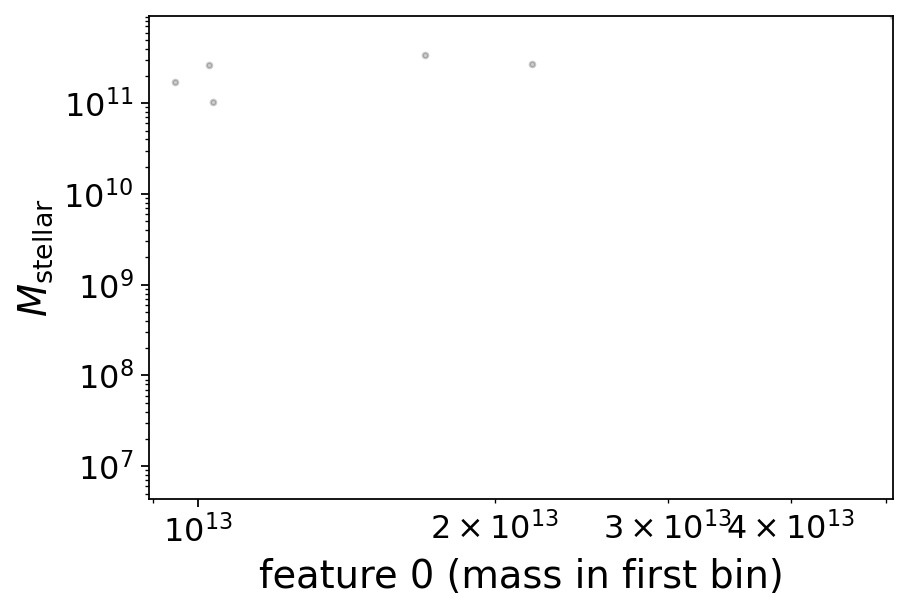

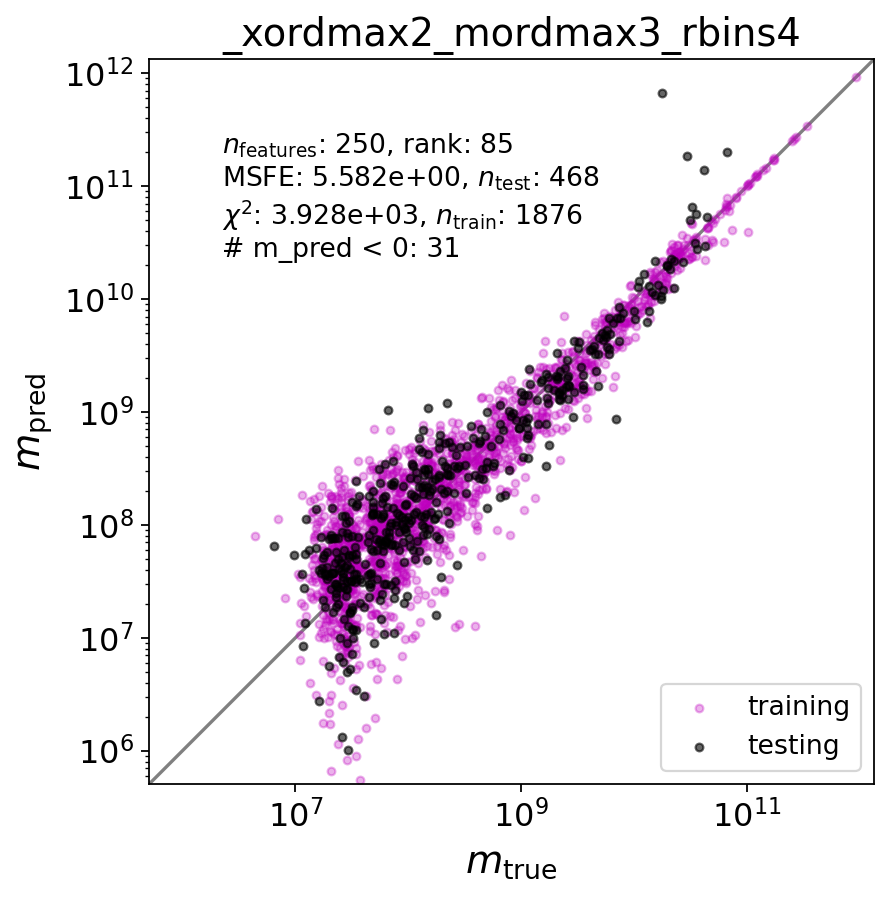

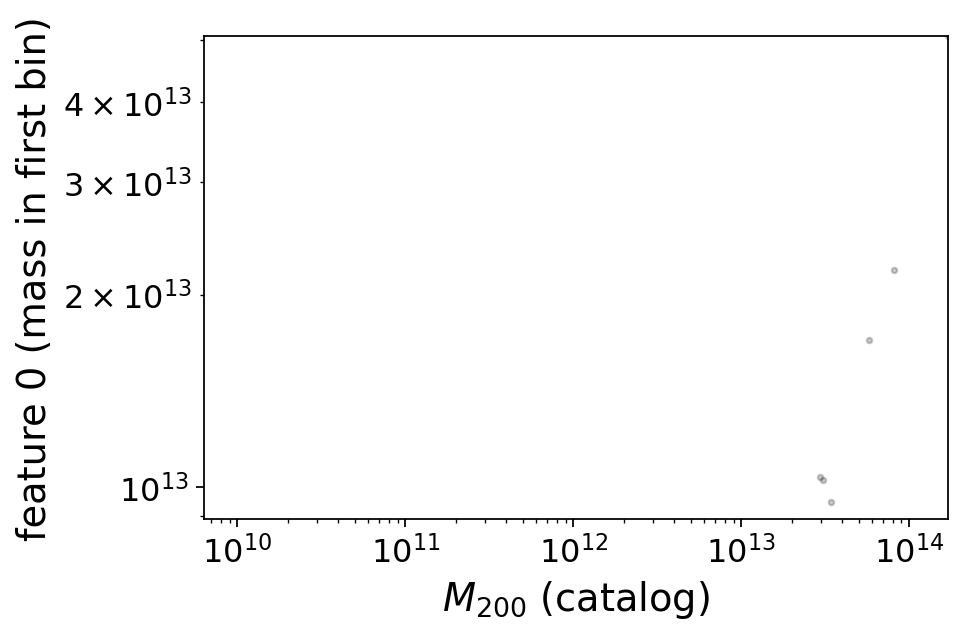

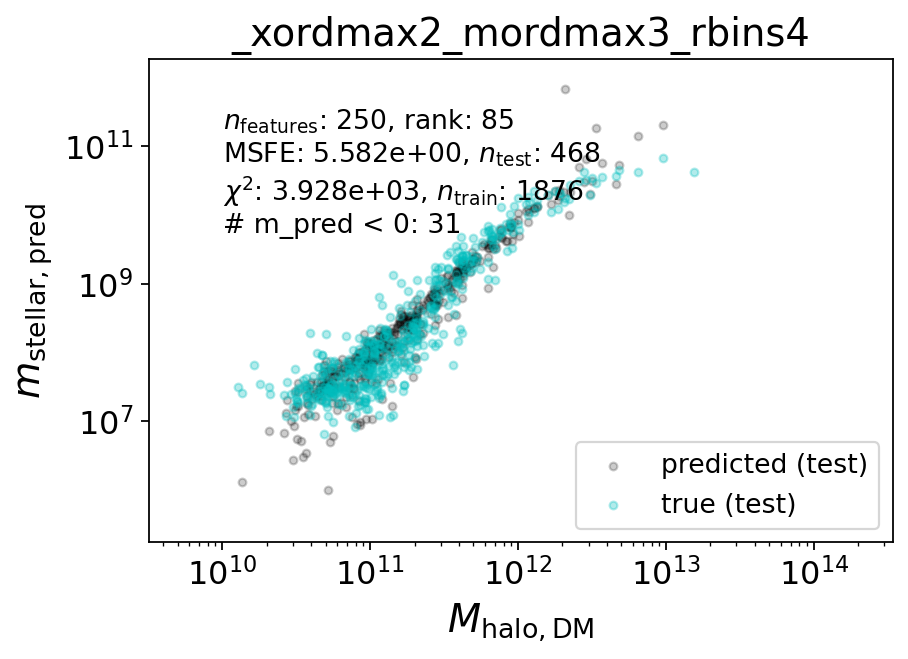

In [15]:
for n_rbins in n_rbins_arr:
    r_edges = np.linspace(0, 1, n_rbins+1)
    featurizer.compute_geometric_features(r_edges, l_arr, r_units=r_units)
    
    for x_order_max in x_order_max_arr:
        for m_order_max in m_order_max_arr:

            # Featurize to order in grid
            featurizer.compute_scalar_features(m_order_max, x_order_max)
            
            if show_intermediate_plots and n_rbins==1:
                plot_feature_vs_label(featurizer)

            # Fit to those features
            fitter = Fitter(featurizer.x_scalar_features, featurizer.y_scalar, 
                        featurizer.x_scalar_dicts, y_val_current, uncertainties=uncertainties)
            fitter.scale(rms_x=rms_x, log_x=log_x, log_y=log_y)
            fitter.split_train_test()
            fitter.fit(check_cond=check_cond)
            fitter.predict()

            # Extract arrays and plot
            y_true = fitter.y_scalar_test*mass_multiplier
            y_pred = fitter.y_scalar_pred*mass_multiplier
            msfe_test = np.mean(((y_pred - y_true)/y_true)**2)

            y_train = fitter.y_scalar_train*mass_multiplier
            A_train = fitter.construct_feature_matrix(fitter.x_scalar_train_scaled, fitter.y_val_current_train)
            y_train_pred_scaled = (A_train @ fitter.theta_scalar)
            y_train_pred = fitter.unscale_y_labels(y_train_pred_scaled)*mass_multiplier

            chi2_train = fitter.chi2
            #chi2_adjusted = np.sqrt(np.sum(((y_train_pred - y_train)/fitter.uncertainties_train)**2))

            save_tag = f'_xordmax{x_order_max}_mordmax{m_order_max}_rbins{n_rbins}{tag}'
            save_fn = f'mass_recovery{save_tag}.png'
            plot_pred_vs_true(y_true, y_pred, y_train, y_train_pred, 
                              fitter, msfe_test, chi2_train, save_fn=save_fn)
            
            masses_all = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer.halo_dicts])*mass_multiplier
            mass = masses_all[fitter.idx_test]
            mass_train = masses_all[fitter.idx_train]

            if show_intermediate_plots and n_rbins==1:
                plot_feature_vs_mass(masses_all, featurizer)
            
            plot_pred_vs_mass(mass, y_true, y_pred, mass_train, y_train, y_train_pred, 
                          fitter, msfe_test, chi2_train, save_fn=save_fn)

In [16]:
fitter.A

array([[1.00000000e+00, 4.36630974e+01, 3.76070414e+01, ...,
        4.81969579e+01, 4.81286950e+01, 4.79089864e+01],
       [1.00000000e+00, 2.80399475e+01, 1.61701647e+01, ...,
        2.57887253e+00, 1.94539308e+00, 1.46903912e+00],
       [1.00000000e+00, 2.27111950e+01, 1.25707383e+01, ...,
        4.58548402e-01, 4.22770953e-01, 2.72113259e-01],
       ...,
       [1.00000000e+00, 1.77040456e-05, 2.44589553e-03, ...,
        5.95552264e-15, 3.88774221e-15, 2.39252578e-15],
       [1.00000000e+00, 1.68490133e-05, 1.63059702e-03, ...,
        2.40320586e-14, 1.46514476e-14, 1.81199191e-14],
       [1.00000000e+00, 6.42507302e-06, 8.15298508e-04, ...,
        1.78914367e-14, 9.12839790e-15, 2.50288698e-14]])

In [17]:
fitter.y_scalar

array([9.16853027e+01, 2.70256691e+01, 3.42160568e+01, ...,
       3.04783904e-03, 1.05185388e-03, 2.91539170e-03])

In [18]:
fitter.x_scalar_features

array([[5.08134591e+03, 3.85263046e+03, 2.82786947e+03, ...,
        1.92591655e+15, 4.03605259e+15, 3.97509395e+15],
       [2.18486213e+03, 2.31746400e+03, 1.38932958e+03, ...,
        1.03049933e+14, 1.63139865e+14, 1.21888793e+14],
       [1.69851888e+03, 1.40097513e+03, 9.93711442e+02, ...,
        1.83232718e+13, 3.54533984e+13, 2.25777219e+13],
       ...,
       [3.30481760e-01, 2.99007307e-01, 1.25897813e-01, ...,
        2.37978498e-01, 3.26024464e-01, 1.98512126e-01],
       [2.20321174e-01, 3.46218987e-01, 1.25897813e-01, ...,
        9.60304168e-01, 1.22866437e+00, 1.50344197e+00],
       [1.10160587e-01, 2.20321174e-01, 9.44233601e-02, ...,
        7.14929231e-01, 7.65503697e-01, 2.07668991e+00]])

In [19]:
fitter.theta_scalar

array([-1.45530897e-03,  5.75128007e-01,  4.94689627e-01,  2.79660028e-01,
       -3.55374833e-01, -1.26286028e-01, -8.66241244e+01, -4.10289907e+01,
        3.93110909e+01,  3.01809785e+01,  3.95759560e+02,  7.91268118e+01,
        5.92739445e+01, -1.38724617e+02,  7.91337764e+01,  5.32444016e+01,
        3.61642164e+00,  7.13351893e+01,  5.92597659e+01,  3.61851423e+00,
       -2.05538050e+02,  1.08506400e+02, -1.38725119e+02,  7.13344504e+01,
        1.08506453e+02, -1.13993452e+02,  2.92314752e+02,  4.84767913e+01,
       -6.82859576e+01, -1.15855366e+01,  4.84768326e+01, -2.19573826e+01,
        2.91240959e+01,  1.83846841e+01, -6.82859914e+01,  2.91240968e+01,
       -4.19427746e+01, -1.03876334e+01, -1.15872891e+01,  1.83846840e+01,
       -1.03876335e+01, -3.66037951e+01, -4.19221522e+03, -2.56413617e+03,
        2.32240488e+03,  2.08138645e+03,  4.30870571e+03, -1.05861560e+03,
       -2.42598490e+03, -3.33207094e+03, -4.28954071e+03,  9.60524721e+02,
        2.03065349e+03, -

In [20]:
# understanding logspace
# x = np.linspace(1, 10, 100)
# y = 0.5*x + 4
# plt.plot(x, y)
#plt.xscale('log')
#plt.yscale('log')

## Broken power law 

the normalization of the SHM
ratio N, a characteristic mass M1, where the ratio is equal
to the normalization N, and two slopes β and γ which indicate the behavior of m/M at the low and high-mass ends,

In [21]:
M = np.logspace(10, 14, 100)
M /= mass_multiplier
m = broken_power_law_feature(M)

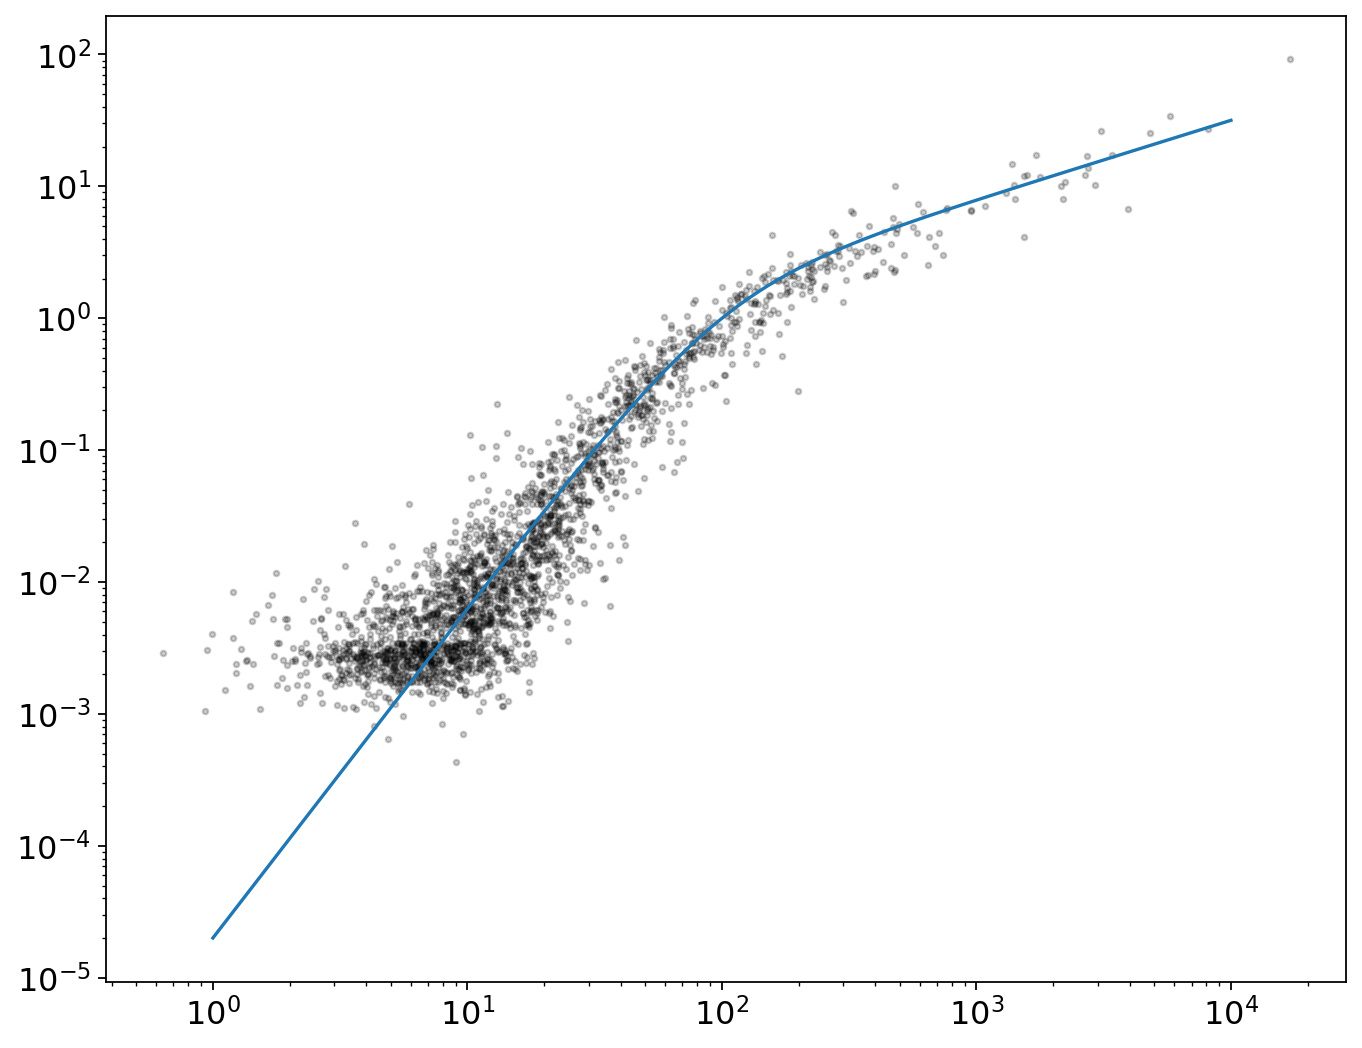

In [22]:
plt.figure(figsize=(10,8))
m200_halo = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer.halo_dicts])
m_stellar = featurizer.y_scalar

plt.scatter(m200_halo, m_stellar, c='k', alpha=0.2, s=6)

plt.plot(M, m)
    
plt.xscale('log')
plt.yscale('log')